https://colab.research.google.com/drive/1tsFuRRizVIEghYq8wBZB4lDvmIR3OJRW

# Step 9 : Add Image Augmentation in Training

_"Once your Model is ready, only then apply **Augmentation**"_ --Successful Student

Target:

1. Add rotation, we guess that 5-7 degrees should be sufficient.
2. Results:
    1. Parameters: 9.8k
    2. Best Train Accuracy: 99.16
    3. Best Test Accuracy: 99.42 (19th Epoch)
3. Analysis:
    1. The model is under-fitting now. This is fine, as we know we have made our training data harder.
    2. The test accuracy is also up, which means our test data had few images that had transformation difference w.r.t. train dataset
    3. We can counter the under-fitting by increasing more layers in the middle.

## 1. Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## 2. Calculate Mean & Standard Deviation of Raw Data to Normalize the Input Data/Tensor Later

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


C:\ProgramData\anaconda3\envs\python39\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 3.1 Record Some Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
cuda = torch.cuda.is_available()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(exp, **dataloader_args)

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


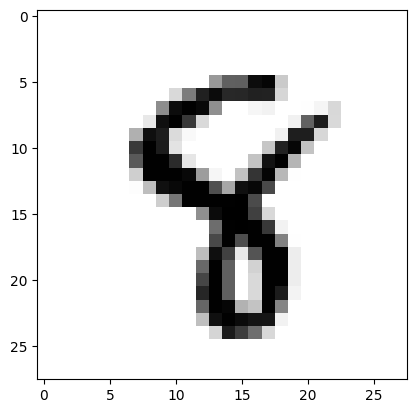

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = exp.train_data
train_data = exp.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## 3.2 A Bit MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

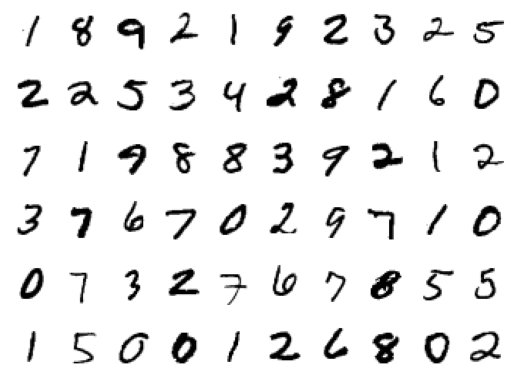

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## 4. Define your NN Model

In [ ]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # X in-out = 28-26 | J in-out = 1-1 | R.F in-out = 1-3 |  | Channels in-out = 1-8

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # X in-out = 26-24 | J in-out = 1-1 | R.F in-out = 3-5 | Channels in-out = 8-16


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # X in-out = 24-12 | J in-out = 1-2 | R.F in-out = 5-6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # X in-out = 12-12 | J in-out = 2-2 | R.F in-out = 6-6 | Channels in-out = 16-8

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # X in-out = 12-10 | J in-out = 2-2 | R.F in-out = 6-10 | Channels in-out = 8-16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # X in-out = 10-8 | J in-out = 2-2 | R.F in-out = 10-14 | Channels in-out = 16-16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # X in-out = 8-6 | J in-out = 2-2 | R.F in-out = 14-18 | Channels in-out = 16-16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # X in-out = 6-6 | J in-out = 2-2 | R.F in-out = 18-22 | Channels in-out = 32-64
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # 1x1x16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU(),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        # INPUT BLOCK
        x = self.convblock1(x)

        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)

        # MAXPOOL 1
        x = self.pool1(x)
        x = self.convblock3(x)

        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        # OUTPUT BLOCK
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=-1)

## 5. Observe the Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

## 6. SEED - finish randomness of PyTorch

Before we start training, get rid of PyTorch SEED Issue

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


## 7. Import & Define Train/Test Data with Normalized Tensors

1.   Define Appropriate Transformations
2.   Apply the Transformations to Input Dataset - both Train & Test


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## 8. Create Dataset Batches

In [ ]:

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

## 9. Define Training and Testing Methods for Neural Network

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## 10. Run, Train and Test the Model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08543651551008224 Batch_id=468 Accuracy=84.33: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.28it/s]



Test set: Average loss: 0.0812, Accuracy: 9787/10000 (97.87%)

EPOCH: 1


Loss=0.13896431028842926 Batch_id=468 Accuracy=97.63: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.74it/s]



Test set: Average loss: 0.0467, Accuracy: 9860/10000 (98.60%)

EPOCH: 2


Loss=0.11541970819234848 Batch_id=468 Accuracy=98.13: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.58it/s]



Test set: Average loss: 0.0396, Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.037659332156181335 Batch_id=468 Accuracy=98.28: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.27it/s]



Test set: Average loss: 0.0394, Accuracy: 9868/10000 (98.68%)

EPOCH: 4


Loss=0.09738552570343018 Batch_id=468 Accuracy=98.57: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.87it/s]



Test set: Average loss: 0.0313, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.00856763869524002 Batch_id=468 Accuracy=98.64: 100%|██████████████████████████| 469/469 [00:15<00:00, 30.55it/s]



Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.02383420057594776 Batch_id=468 Accuracy=98.73: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.71it/s]



Test set: Average loss: 0.0301, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.10722741484642029 Batch_id=468 Accuracy=98.83: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.66it/s]



Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.03254486247897148 Batch_id=468 Accuracy=98.82: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.93it/s]



Test set: Average loss: 0.0219, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.051362305879592896 Batch_id=468 Accuracy=98.85: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.27it/s]



Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.04352198541164398 Batch_id=468 Accuracy=98.93: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.87it/s]



Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.007848204113543034 Batch_id=468 Accuracy=99.01: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.87it/s]



Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.06115071475505829 Batch_id=468 Accuracy=99.03: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.50it/s]



Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.035305049270391464 Batch_id=468 Accuracy=99.05: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.27it/s]



Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.024017518386244774 Batch_id=468 Accuracy=99.04: 100%|█████████████████████████| 469/469 [00:15<00:00, 30.35it/s]



Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.01055501401424408 Batch_id=468 Accuracy=99.08: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.81it/s]



Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.00933146383613348 Batch_id=468 Accuracy=99.16: 100%|██████████████████████████| 469/469 [00:14<00:00, 31.34it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.037721917033195496 Batch_id=468 Accuracy=99.06: 100%|█████████████████████████| 469/469 [00:14<00:00, 31.70it/s]



Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.03334718942642212 Batch_id=468 Accuracy=99.09: 100%|██████████████████████████| 469/469 [00:15<00:00, 30.20it/s]



Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.007360544055700302 Batch_id=468 Accuracy=99.12: 100%|█████████████████████████| 469/469 [00:15<00:00, 29.99it/s]



Test set: Average loss: 0.0214, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

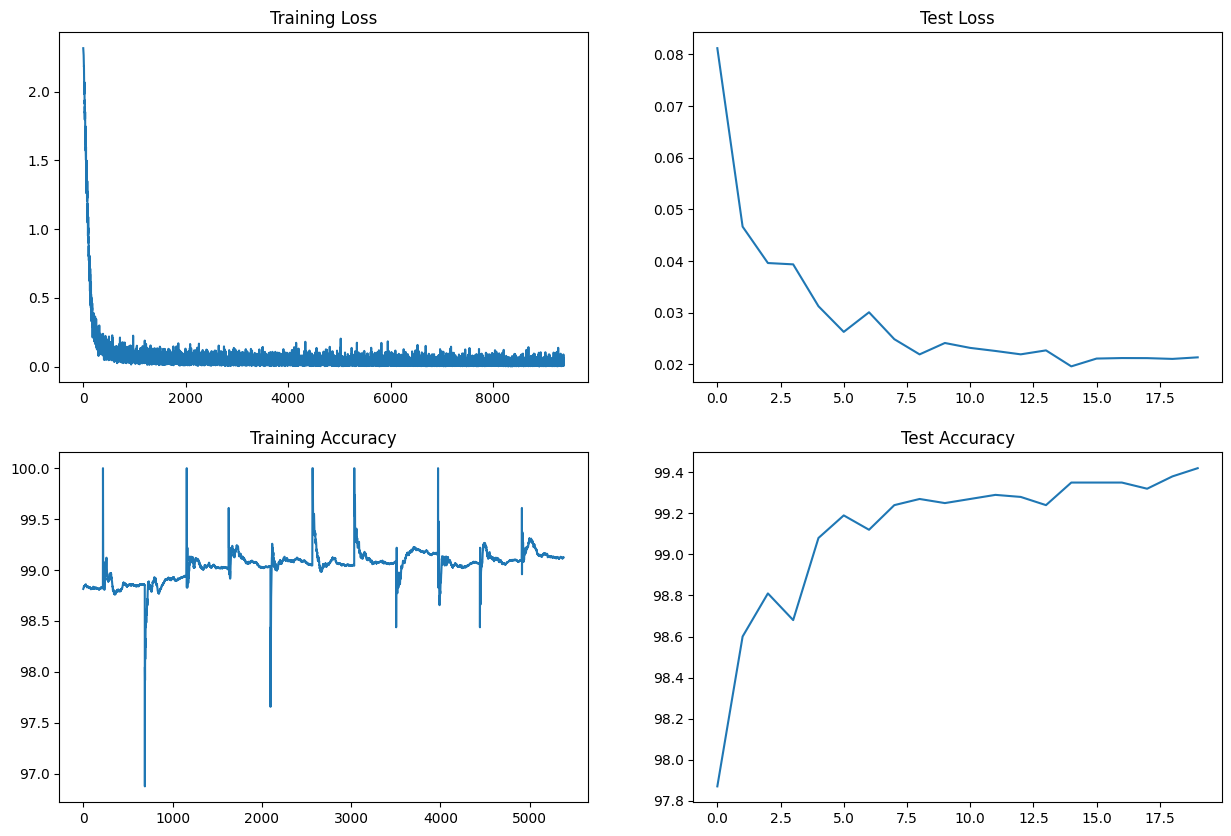

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")